# Урок 4. Image Segmentation

ЗАДАНИЕ 1. Необходимо доработать обучение нейросети, что мы разбирали на уроке.(Посмотрите чего не хватает в процессе обучения и подготовки данных)

In [1]:
import torch
import torch.nn as nn

In [2]:
def crop_tensor(target_tensor, tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2
    
    return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]

In [3]:
import torch
import torch.nn as nn

class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        # Левая сторона (Путь уменьшения размерности картинки)
        self.down_conv_11 = self.conv_block(in_channels=3, out_channels=64)
        self.down_conv_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_21 = self.conv_block(in_channels=64, out_channels=128)
        self.down_conv_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_31 = self.conv_block(in_channels=128, out_channels=256)
        self.down_conv_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_41 = self.conv_block(in_channels=256, out_channels=512)
        self.down_conv_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        
        # Правая сторона (Путь увеличения размерности картинки)
        self.up_conv_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.up_conv_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_22 = self.conv_block(in_channels=512, out_channels=256)
        self.up_conv_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_32 = self.conv_block(in_channels=256, out_channels=128)
        self.up_conv_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_42 = self.conv_block(in_channels=128, out_channels=64)
        
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
    
    @staticmethod
    def conv_block(in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    @staticmethod
    def crop_tensor(target_tensor, tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2

        return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]


    def forward(self, X):
        # Проход по левой стороне
        x1 = self.down_conv_11(X) # [-1, 64, 256, 256]
        x2 = self.down_conv_12(x1) # [-1, 64, 128, 128]
        x3 = self.down_conv_21(x2) # [-1, 128, 128, 128]
        x4 = self.down_conv_22(x3) # [-1, 128, 64, 64]
        x5 = self.down_conv_31(x4) # [-1, 256, 64, 64]
        x6 = self.down_conv_32(x5) # [-1, 256, 32, 32]
        x7 = self.down_conv_41(x6) # [-1, 512, 32, 32]
        x8 = self.down_conv_42(x7) # [-1, 512, 16, 16]
        
        middle_out = self.middle(x8) # [-1, 1024, 16, 16]

        # Проход по правой стороне
        x = self.up_conv_11(middle_out) # [-1, 512, 32, 32]
        y = self.crop_tensor(x, x7)
        x = self.up_conv_12(torch.cat((x, y), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        
        x = self.up_conv_21(x) # [-1, 256, 64, 64]
        y = self.crop_tensor(x, x5)
        x = self.up_conv_22(torch.cat((x, y), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        
        x = self.up_conv_31(x) # [-1, 128, 128, 128]
        y = self.crop_tensor(x, x3)
        x = self.up_conv_32(torch.cat((x, y), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        
        x = self.up_conv_41(x) # [-1, 64, 256, 256]
        y = self.crop_tensor(x, x1)
        x = self.up_conv_42(torch.cat((x, y), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        
        output = self.output(x) # [-1, num_classes, 256, 256]

        return output

In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [5]:
#Найдем уникальные значения пискселей на картинке, и каждое такое значение будет соответсвовать целому классу.
np.unique(plt.imread('archive/dataA/dataA/CameraSeg/02_00_000.png')[:,:,0]*255)

array([ 0.,  1.,  2.,  3.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
      dtype=float32)

В итоге видим, что у нас 13 классов.  
Но класс №4 отсутствует, поэтому у нас в итоге 12 классов
Отображение семантической маски 
для каждого класса используя код ниже:

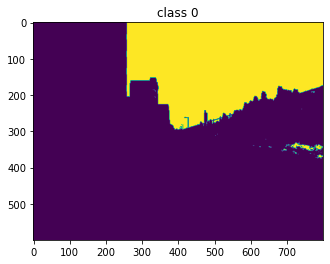

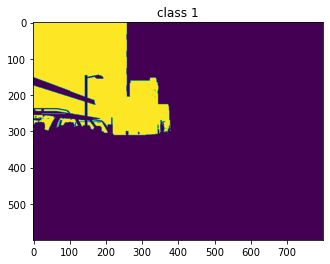

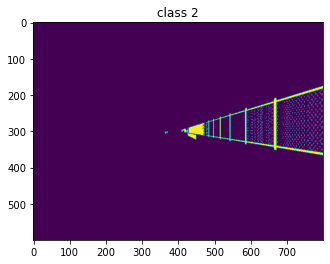

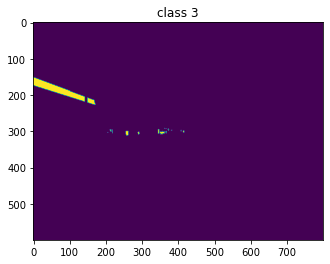

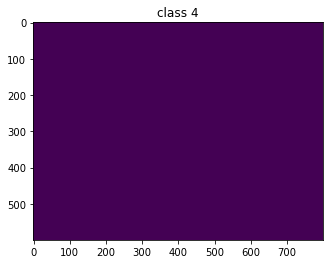

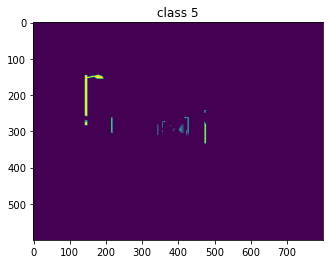

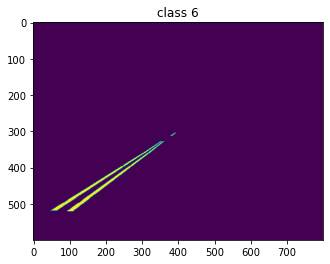

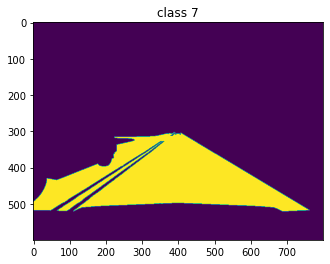

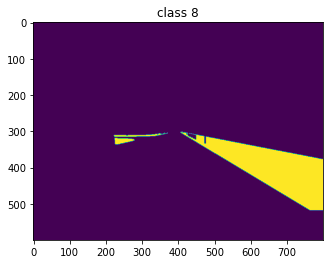

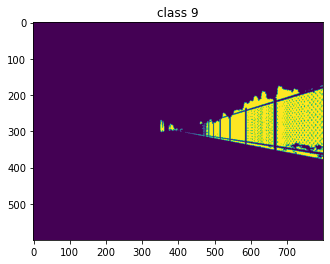

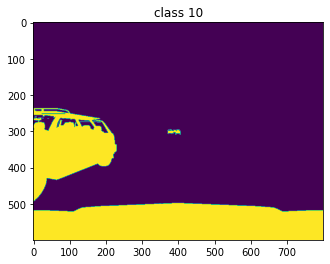

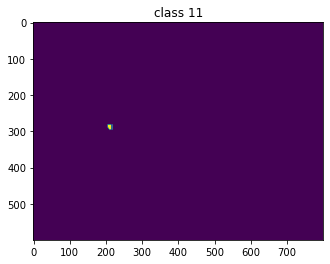

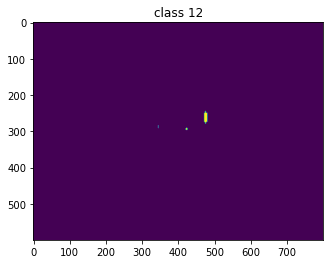

In [6]:
for i in range(13):
    mask = plt.imread('archive/dataA/dataA/CameraSeg/02_00_000.png')*255
    mask = np.where(mask == i, 255, 0)
    mask = mask[:,:,0]
    plt.title(f'class {i}')
    plt.imshow(mask)
    plt.show()

In [7]:
#Название классов
labels = ['Unlabeled','Building','Fence','Other',
                'Pedestrian', 'Pole', 'Roadline', 'Road',
                'Sidewalk', 'Vegetation', 'Car','Wall',
                 'Traffic sign']
#С учетом что нет 4 класса имеем
labels = ['Unlabeled','Building','Fence','Other',
                 'Pole', 'Roadline', 'Road',
                'Sidewalk', 'Vegetation', 'Car','Wall',
                 'Traffic sign']


In [8]:
class_count=len(labels)
class_count

12

In [9]:
#Теперь приведем наш датасет к удобному виду, для этого сначала разделим все на два списка с rgb картинками и seg.
cameraRGB = []
cameraSeg = []
for root, dirs, files in os.walk('archive'):
    for name in files:
        f = os.path.join(root, name)
        if 'CameraRGB' in f:
            cameraRGB.append(f)
        elif 'CameraSeg' in f:
            cameraSeg.append(f)
        else:
            break

In [10]:
#Теперь завернем эти два списка в DataFrame из библиотеки pandas.В итоге выведем первые пять записей из получившегося датафрейма:
df = pd.DataFrame({'cameraRGB': cameraRGB, 'cameraSeg': cameraSeg})
# Отсортируем  датафрейм по значениям
df.sort_values(by='cameraRGB',inplace=True)
# Используем функцию,
# лагодаря которой индексация значений 
# будет начинаться с 0.
df.reset_index(drop=True, inplace=True)
# Выведем первые ять значений нашего датафрейма
print(df.head(5))

                                     cameraRGB  \
0  archive\dataA\dataA\CameraRGB\02_00_000.png   
1  archive\dataA\dataA\CameraRGB\02_00_001.png   
2  archive\dataA\dataA\CameraRGB\02_00_010.png   
3  archive\dataA\dataA\CameraRGB\02_00_011.png   
4  archive\dataA\dataA\CameraRGB\02_00_020.png   

                                     cameraSeg  
0  archive\dataA\dataA\CameraSeg\02_00_000.png  
1  archive\dataA\dataA\CameraSeg\02_00_001.png  
2  archive\dataA\dataA\CameraSeg\02_00_010.png  
3  archive\dataA\dataA\CameraSeg\02_00_011.png  
4  archive\dataA\dataA\CameraSeg\02_00_020.png  


In [11]:
#Теперь обернем все в кастомный датасет для удобной работы в PyTorch.
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F

In [12]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 1) unsqueeze - меняет размерность img c (600, 800, 3) -> (1, 600, 800, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, 600, 800, 3) -> (1, 3, 600, 800)
        img = img.unsqueeze(0).permute(0,3,1,2)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять размерность картинки с 800х600 на 256х256
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
        # читаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        lab = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
        
        # Упаковываем ее в pytorch-тензор и оборачиваем ее в батч из одной каринки,
        # но при этом заполняем 12 каналов масками нужных классов
        # Т.е. там, где например класс автомобилей (10 по счету канал) - все пиксели 0 
        # если не принадлежат классу, и 1 если принадлежат 
        x_out = torch.as_tensor(np.where(lab == 0, 255, 0)).unsqueeze(0)
        for i in range(1, class_count+1):
            if i!=4:
                mask = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
                mask = np.where(mask == i, 255, 0)
                x = torch.as_tensor(mask).unsqueeze(0)
                x_out =  torch.cat((x_out,x),dim=0)       
        x_out = x_out.float()
        
        lab = x_out.unsqueeze(0)
        # делаем ресайз картинки на 256х256
        lab = F.interpolate(input=lab, size=256, mode='nearest')
        
        
        
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

In [13]:
#Затем разделим наш датасет на тренировочную и тестовую выборки.И обернем их в наш кастомный класс.
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df,test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [14]:
#И теперь уже обернем то, что получилось в известные нам в pytorch даталоадеры:
train_data_loader = DataLoader(train_data,batch_size=1,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=1,shuffle=False)

**Обучение**

In [15]:
#Определим скорость обучения и количество эпох:
learning_rate = 0.001
epochs = 1 #5

In [16]:
#Выберем устройство,на котором будем обучать нашу модель:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [17]:
print("количество классов=",class_count)

количество классов= 12


In [18]:
#Определим нашу модель Unet для 12 классов:
Umodel = UNet(num_classes=class_count).to(device)

In [19]:
#Под обучением мы понимаем скармливание целевой функции оптимизирующей функции. Поэтому выберем оптимизирующую функцию и функцию потерь (целевая функция):
optimizer = torch.optim.Adam(Umodel.parameters(), lr=0.001)

In [20]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth =1
        num = targets.size(0)
        probs = F.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score =2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score =1 - score.sum() / num
        return score

In [21]:
criterion = SoftDiceLoss()

In [22]:
#Определим количество шагов внутри одной эпохи:
total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")

1 epochs, 3500 total_steps per epoch


Запускаем сам процесс обучения:

In [23]:
#Импортируем библиотеку time для расчета, сколько времени у нас уходит на одну эпоху
import time
from torch.autograd import Variable

# Полезная функция для детектирования аномалий в процессе обучения
#torch.autograd.set_detect_anomaly(True)

# запускаем главный тренировочный цикл
epoch_losses = []
for epoch in range(epochs):
    
    time1 = time.time()
    running_loss =0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_data_loader):
        
        data, labels = Variable(data), Variable(labels)        
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = Umodel(data[0])

        loss = criterion(outputs, labels[0])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 300 == 299:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/300}')
            time2 = time.time()
            print(f'Spend time for 300 images: {time2-time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

C:\Users\Windows\Anaconda3\envs\python38\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1, Loss: -0.900706262588501
Spend time for 300 images: 1445.9973289966583 sec
Train Epoch: 1, Loss: -0.9530662099520365
Spend time for 300 images: 1454.4677183628082 sec
Train Epoch: 1, Loss: -0.9562319235006969
Spend time for 300 images: 1457.4828922748566 sec
Train Epoch: 1, Loss: -0.9608522121111552
Spend time for 300 images: 1477.1426124572754 sec
Train Epoch: 1, Loss: -0.9627369074026744
Spend time for 300 images: 1477.8310799598694 sec
Train Epoch: 1, Loss: -0.9597461358706156
Spend time for 300 images: 1456.5343737602234 sec
Train Epoch: 1, Loss: -0.9621668593088786
Spend time for 300 images: 1449.7430567741394 sec
Train Epoch: 1, Loss: -0.9638685178756714
Spend time for 300 images: 1452.9288833141327 sec
Train Epoch: 1, Loss: -0.9661186389128367
Spend time for 300 images: 1438.287829875946 sec
Train Epoch: 1, Loss: -0.9661239055792491
Spend time for 300 images: 1452.0241014957428 sec
Train Epoch: 1, Loss: -0.9678899510701497
Spend time for 300 images: 1462.75989866

In [24]:
savePATH = './selfLastModel1.pth'
torch.save(Umodel.state_dict(), savePATH)

In [25]:
net=UNet(class_count)
net.load_state_dict(torch.load(savePATH))

<All keys matched successfully>

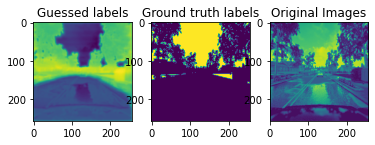

<ipython-input-26-fd8fc7563aff>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.gcf().show()


<Figure size 432x288 with 0 Axes>

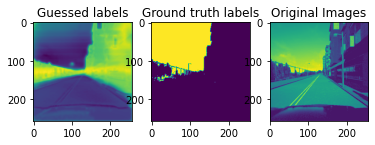

<Figure size 432x288 with 0 Axes>

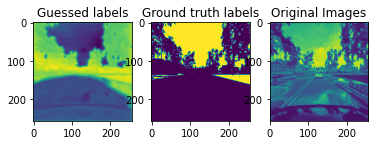

<Figure size 432x288 with 0 Axes>

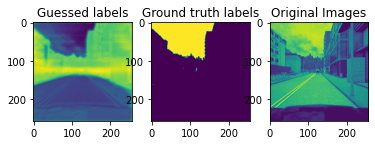

<Figure size 432x288 with 0 Axes>

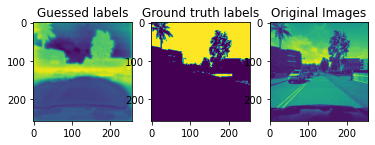

<Figure size 432x288 with 0 Axes>

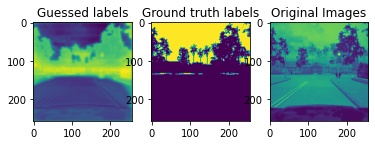

<Figure size 432x288 with 0 Axes>

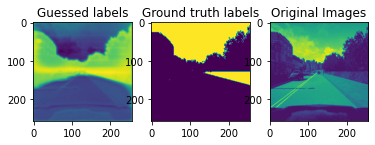

<Figure size 432x288 with 0 Axes>

In [26]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    outputs = net(images[0])
    f, axarr = plt.subplots(1,3)

    axarr[0].imshow(outputs[0].detach().cpu().numpy()[1,:,:])
    axarr[0].set_title('Guessed labels')
    
    axarr[1].imshow(labels[0].detach().cpu().numpy()[0,0,:,:])
    axarr[1].set_title('Ground truth labels')
    
    axarr[2].imshow(images[0].detach().cpu().numpy()[0,0,:,:])
    axarr[2].set_title('Original Images')
    plt.show()
    plt.gcf().show()
    if i>5:
        break

**Вывод - для сходимости модели надо было убрать класс №4 - и тогда получается всего 12 классов для обучения - этого и не хватало в  процессе обучения и подготовки данных - как результат:**

**меняем строку: Umodel = UNet(num_classes=len(labels)).to(device)**

**Также меняем код в CustomDatasetFromImages - не делаем маску для тензора картинки для 4 класса**

ЗАДАНИЕ 2. Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks для обучения.

In [28]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

**Подготовка датасета**

Начнем с того, что посмотрим на наш датасет. Внутри куча схожих по названию папок, каждая из которых содержит картинки. 
Но мы можем выделить в этом датасете два вида картинок. 
1) Это обычные цветные картинки.
Например set-lipstick-original/720p/image00000001.jpg
2) И есть связанные с ними картинки, разбитые на области с одинаковыми яркостями пикселей.
Например set-lipstick-original/mask/mask00000001.png, в ней все тоже самое, что и в первой, но  она просегментирована.

Найдем уникальные значения пискселей на картинке, и каждое такое значение будет соответсвовать целому классу.

In [59]:
np.unique(plt.imread('set-lipstick-original/mask/mask00000001.png')[:,:,0]*255)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  71.,  72.,  74.,  75.,  76.,  78.,  86.,  93.,
       101.], dtype=float32)

In [51]:
class_count=0
for root, dirs, files in os.walk('set-lipstick-original/mask'):
    for name in files:
        f = os.path.join(root, name)    
        try:
            if int(max(np.unique(plt.imread(f)[:,:,0]*255))) > class_count:        
                class_count=int(max(np.unique(plt.imread(f)[:,:,0]*255)))
        except IndexError:
            pass
            
            
     

In [60]:
#т.к. в разных картинках уникальные значения пикселей (классов) могут  не пересекаться, то будем считать что максимальное значение из массива из
# уникальных значений на картинках + 1 (0 значение) и есть количество классов
class_count=159 #полученное из вычисления предыдущей ячейки, max arr len=111
class_count=class_count+1
class_count

160

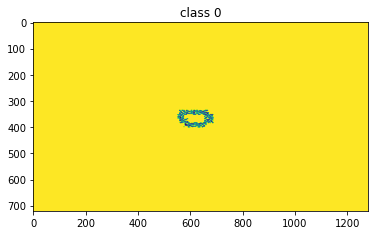

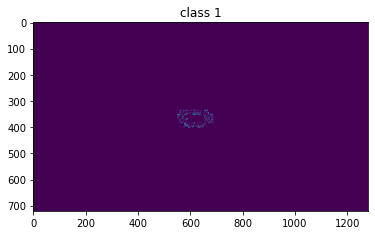

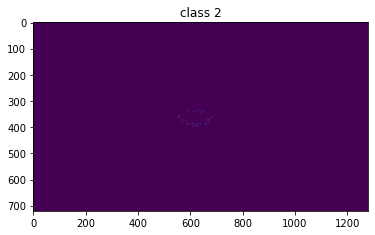

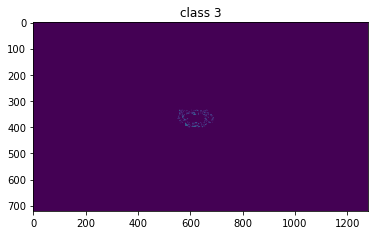

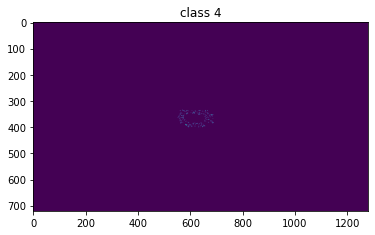

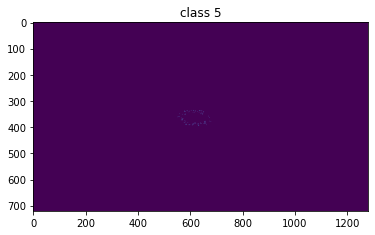

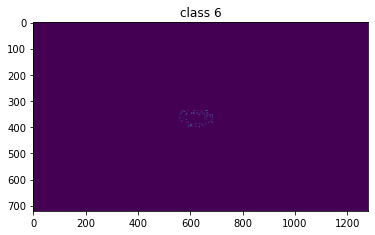

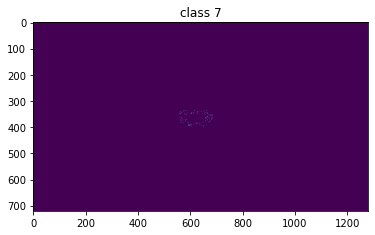

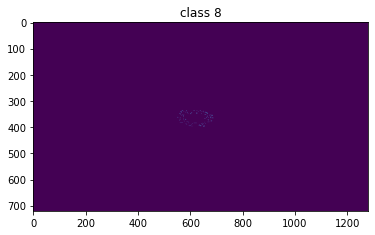

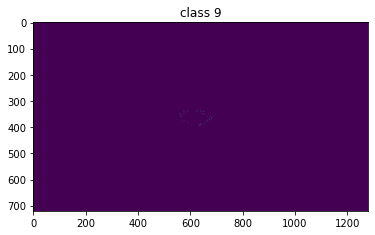

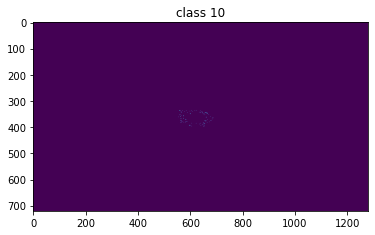

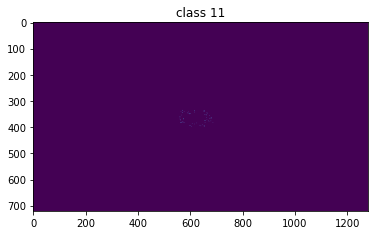

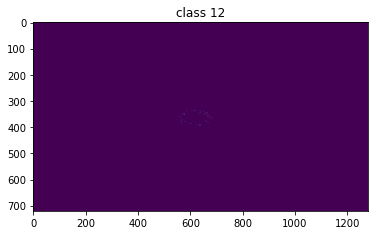

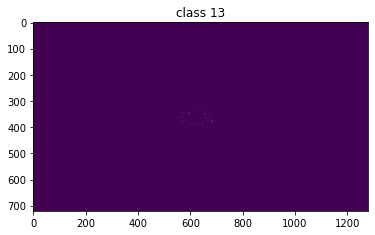

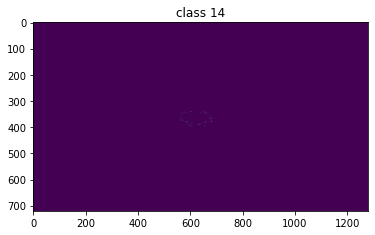

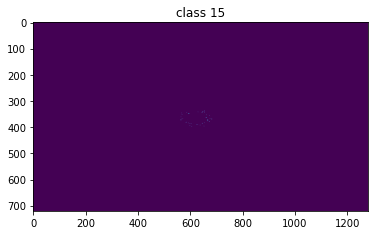

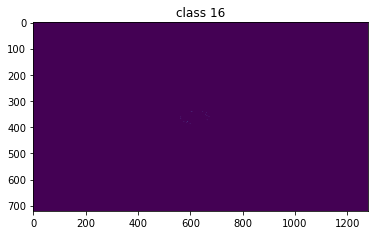

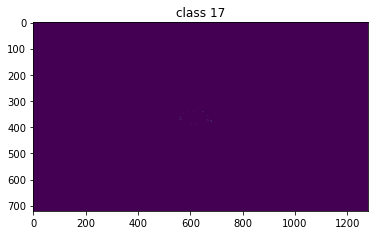

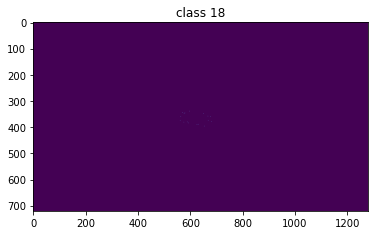

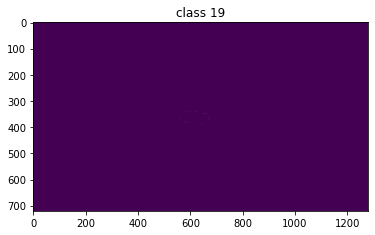

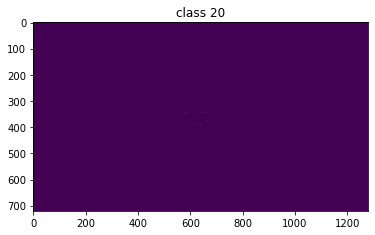

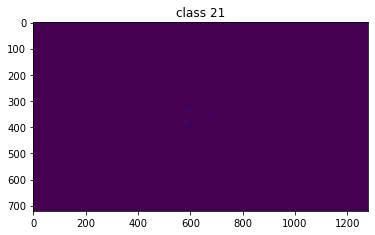

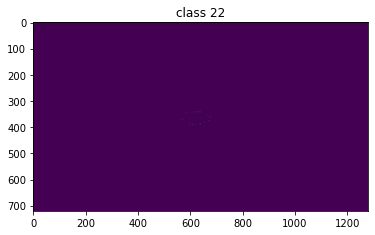

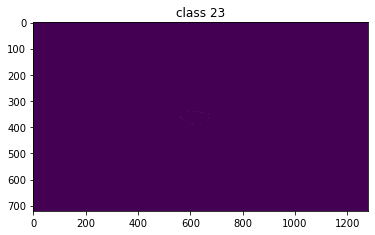

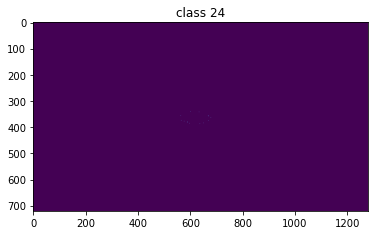

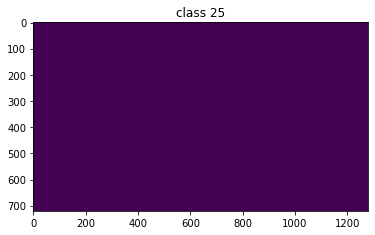

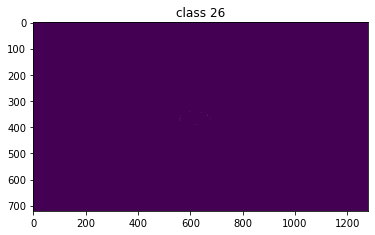

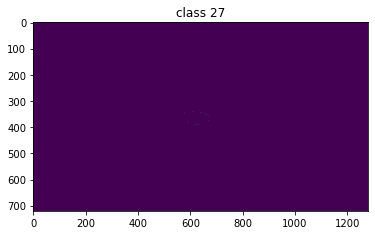

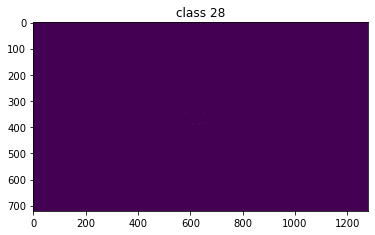

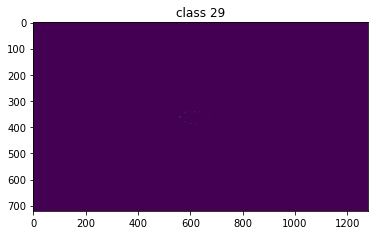

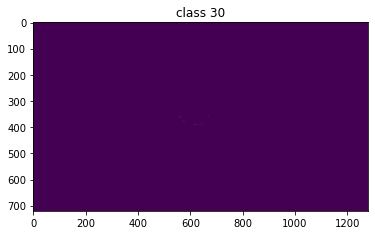

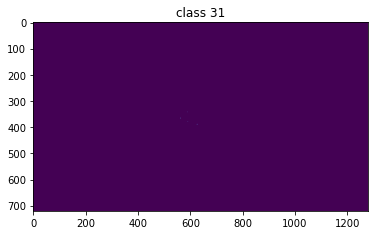

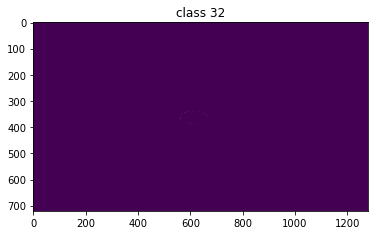

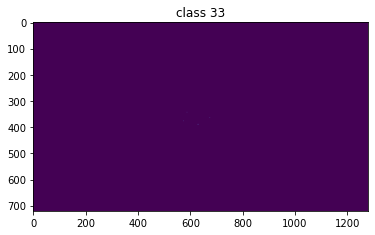

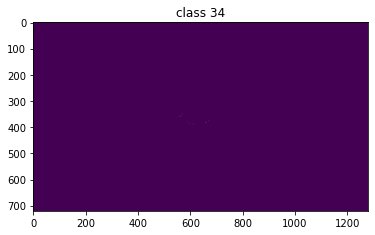

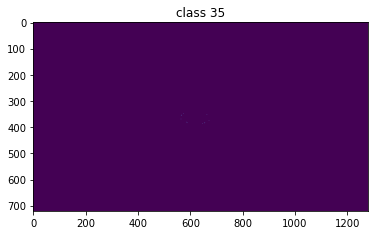

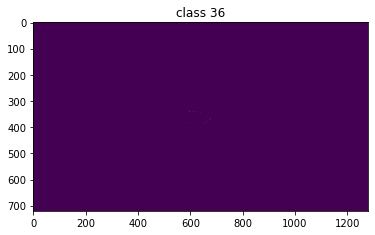

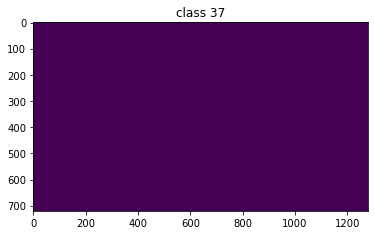

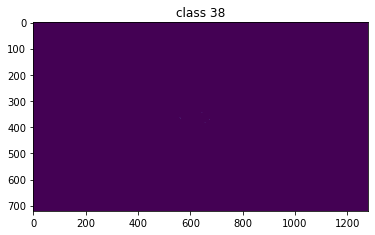

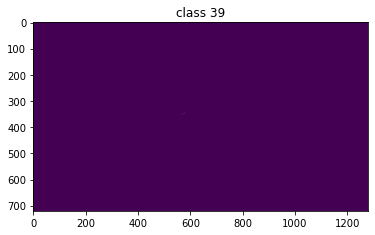

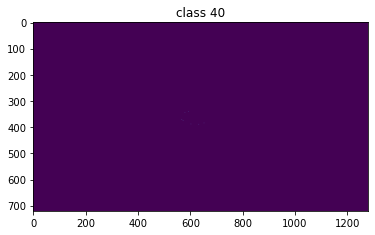

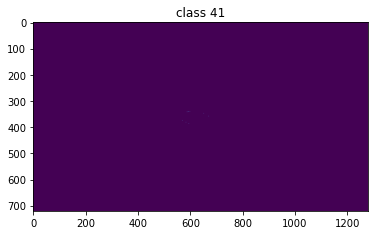

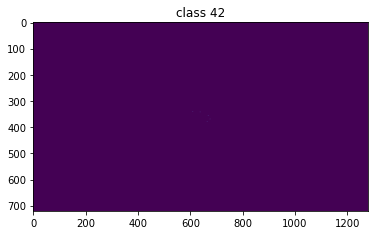

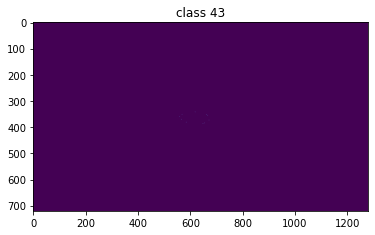

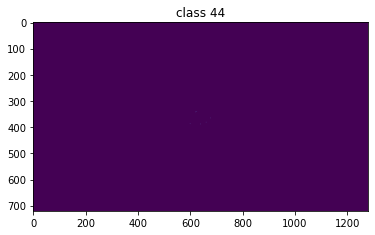

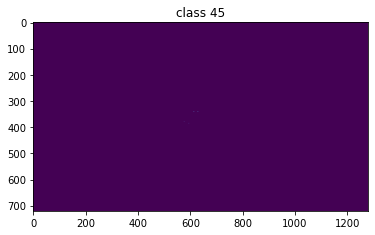

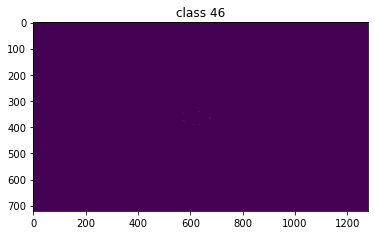

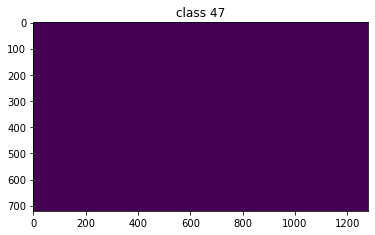

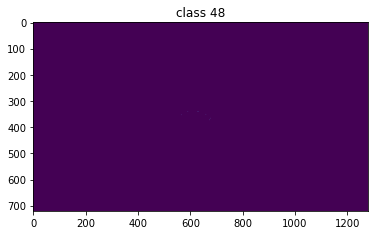

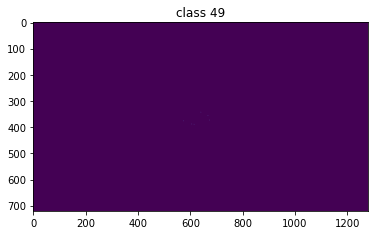

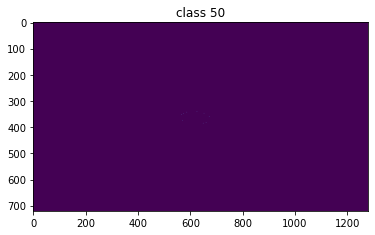

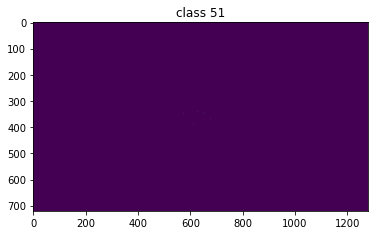

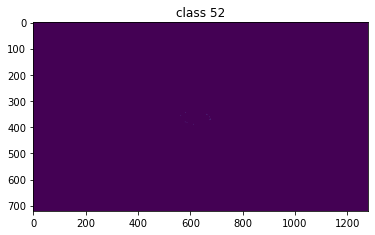

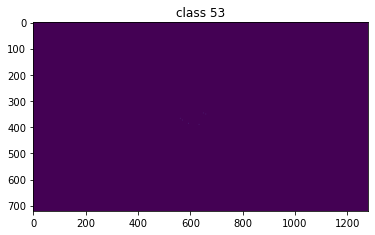

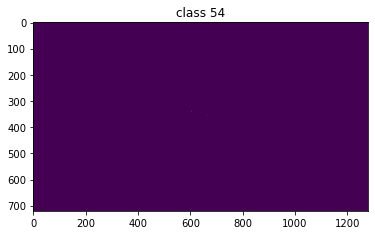

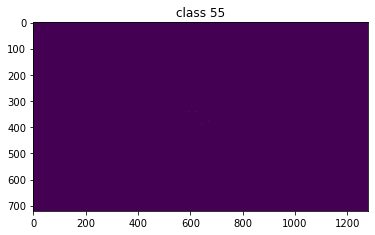

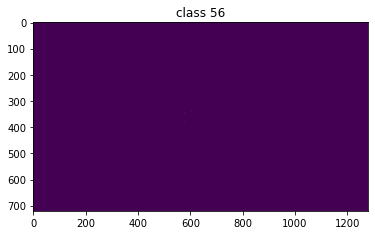

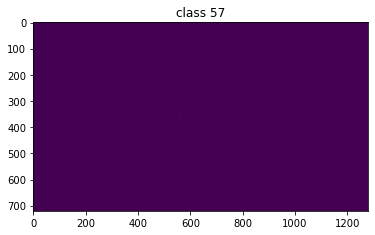

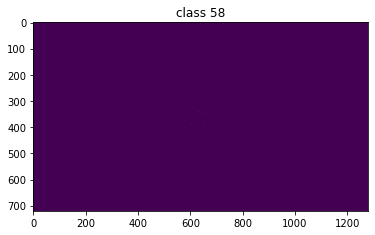

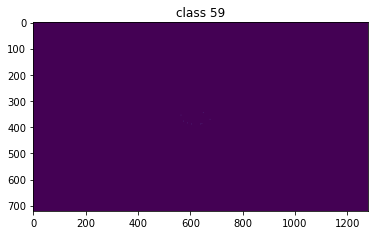

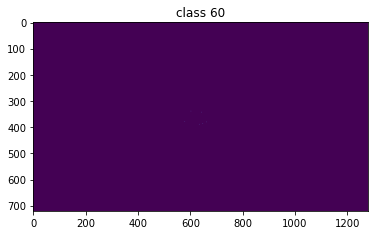

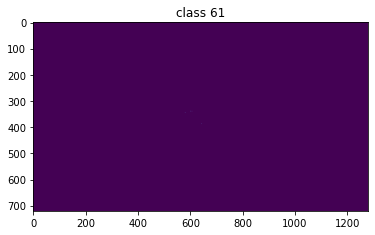

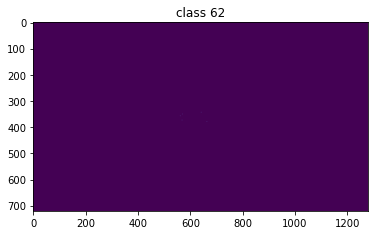

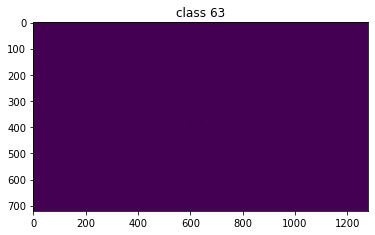

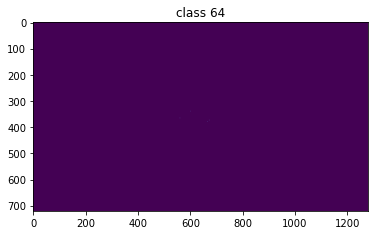

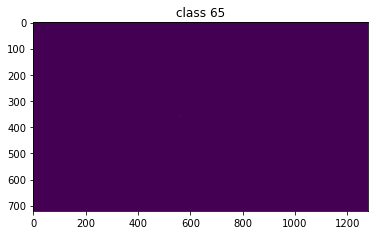

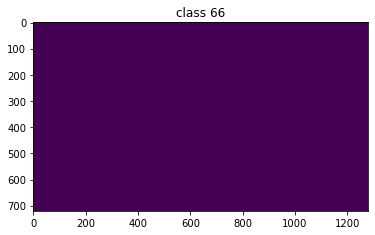

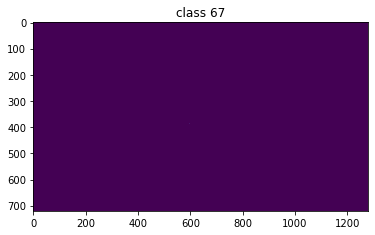

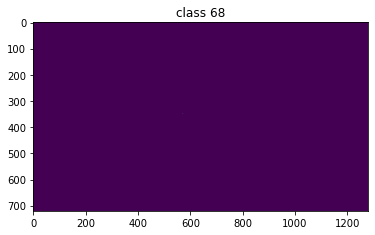

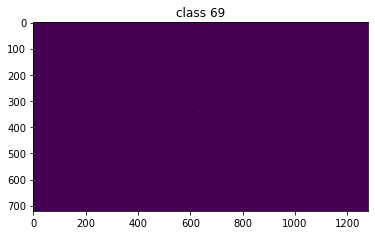

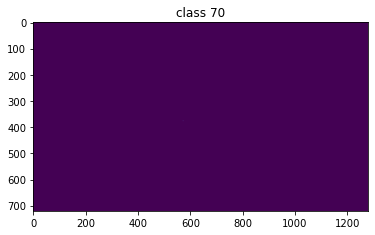

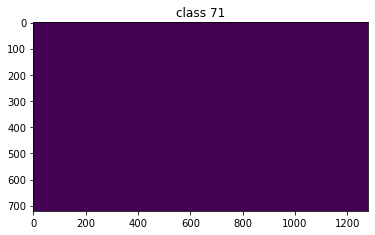

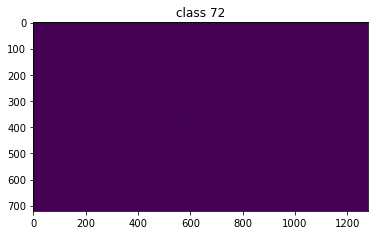

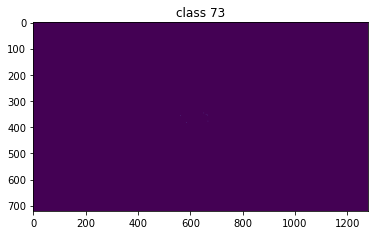

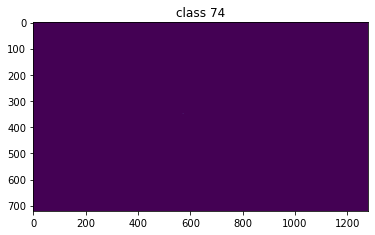

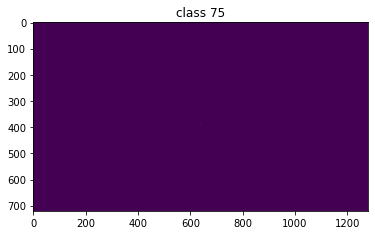

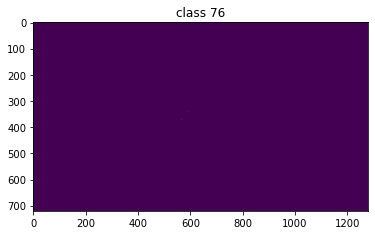

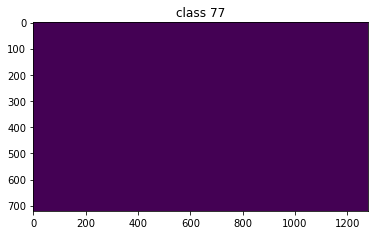

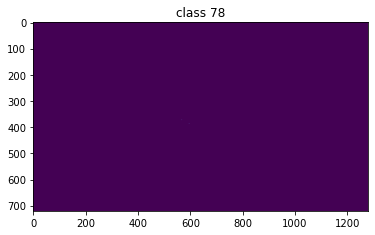

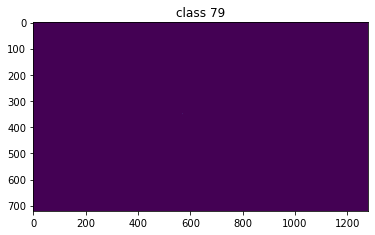

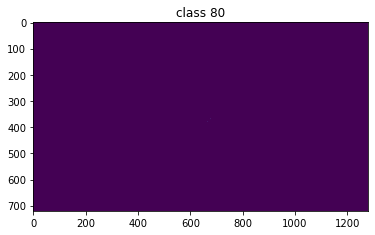

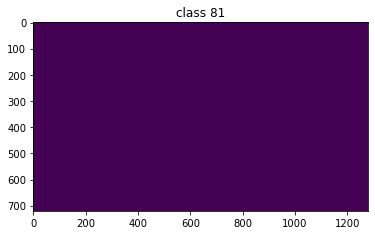

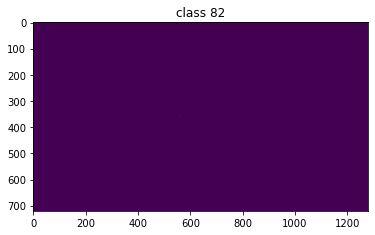

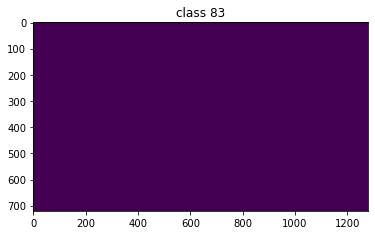

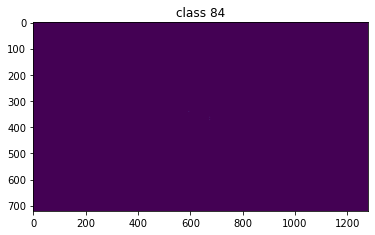

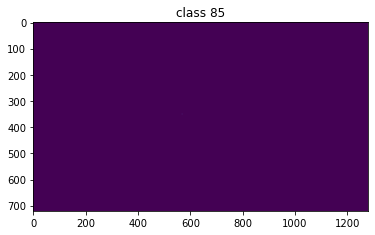

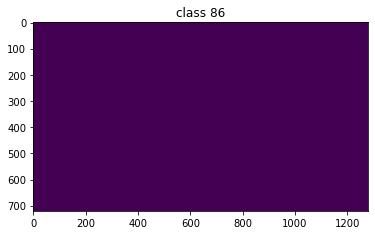

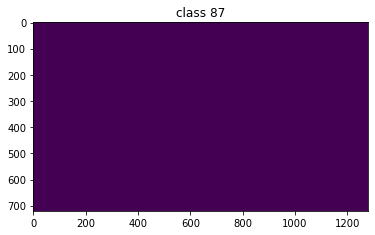

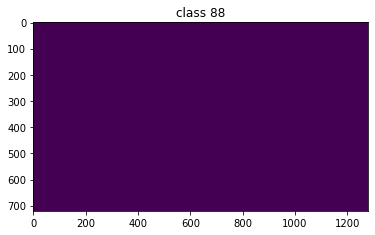

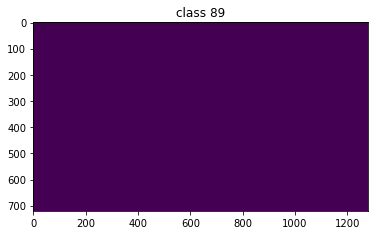

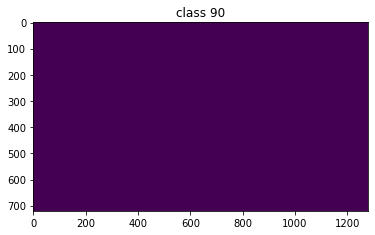

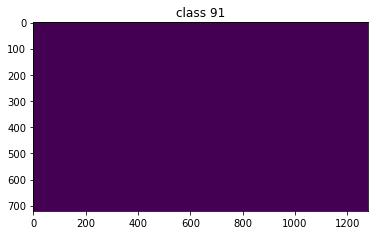

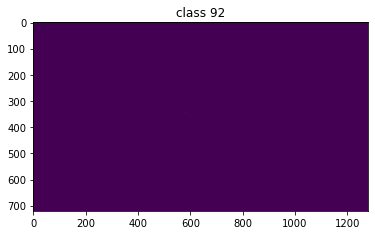

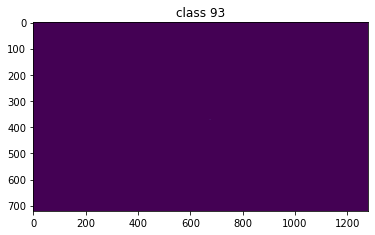

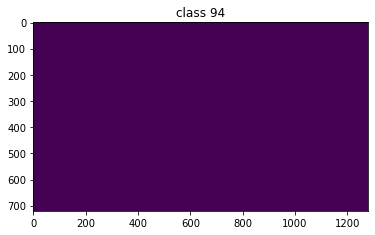

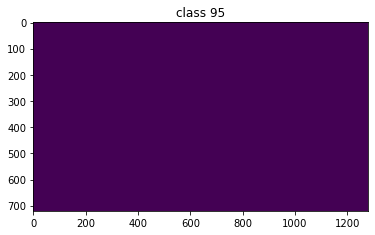

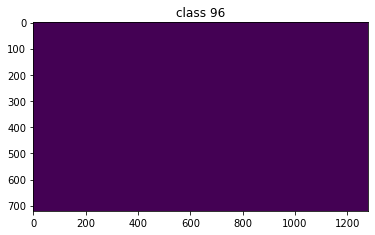

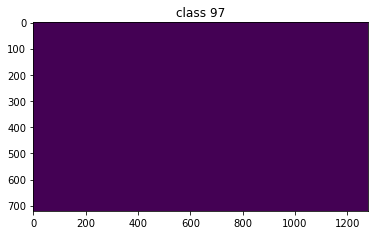

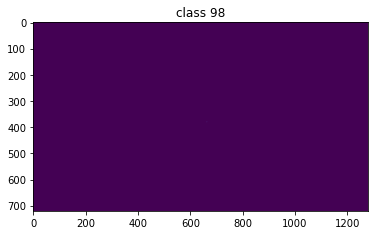

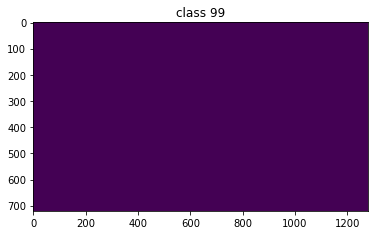

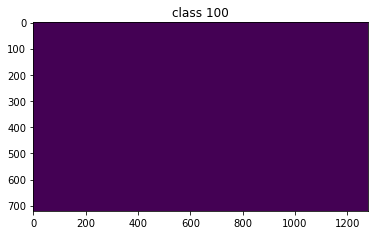

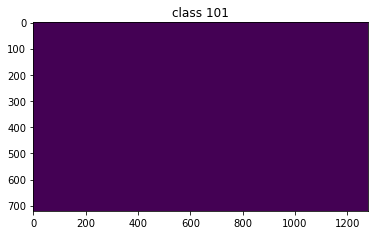

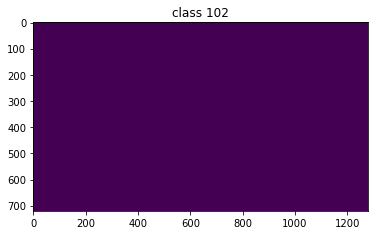

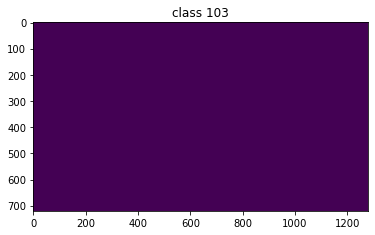

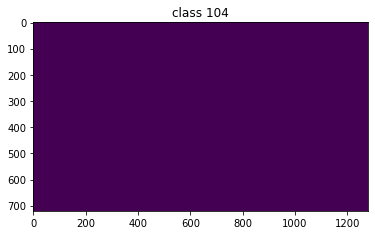

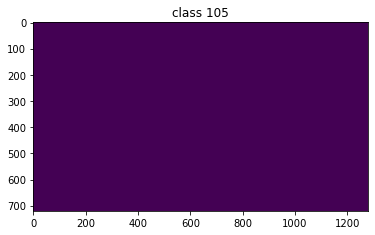

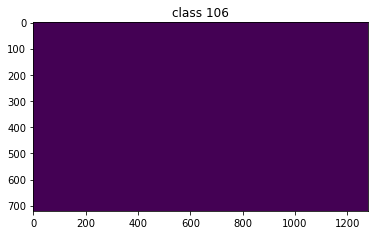

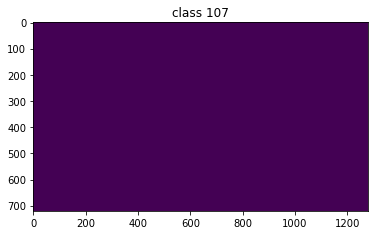

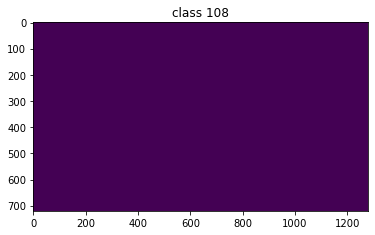

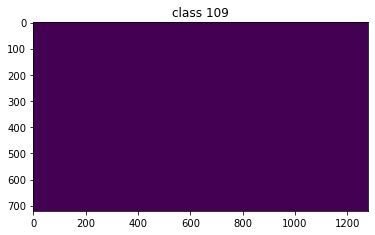

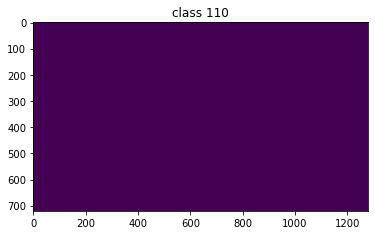

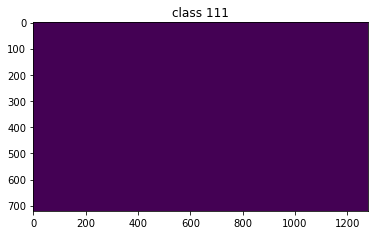

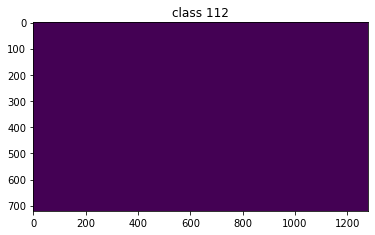

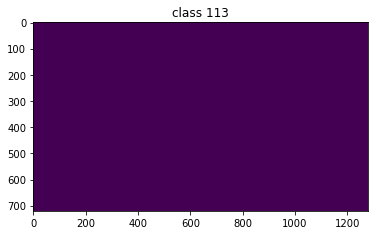

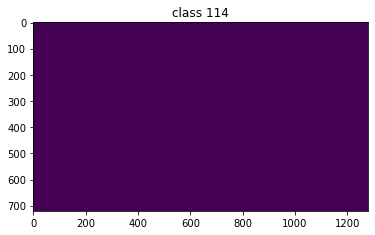

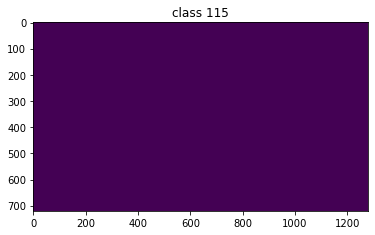

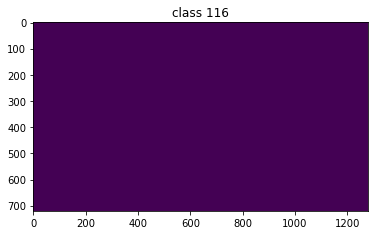

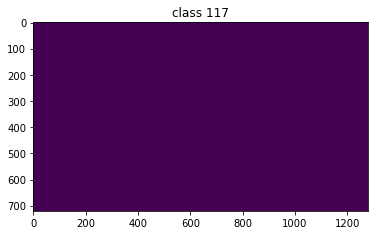

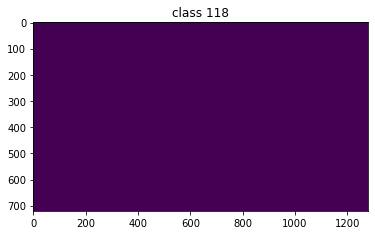

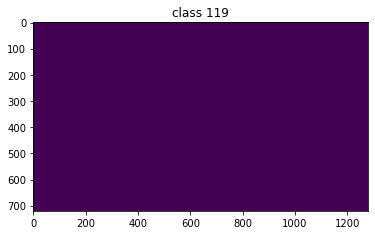

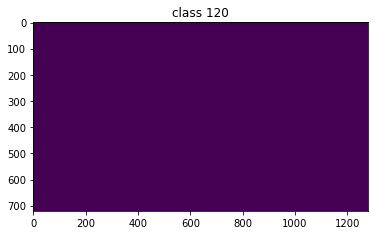

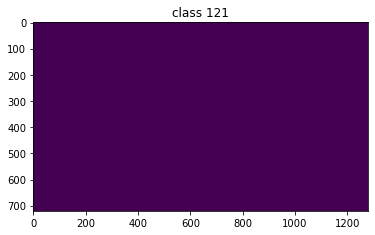

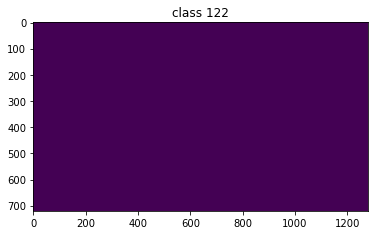

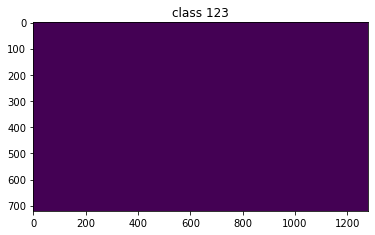

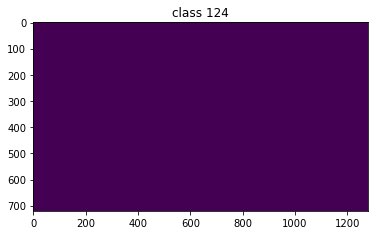

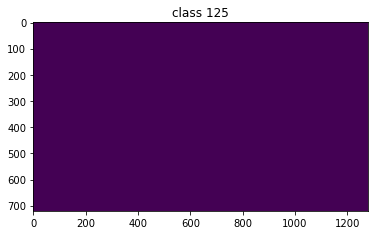

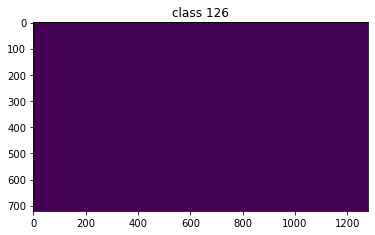

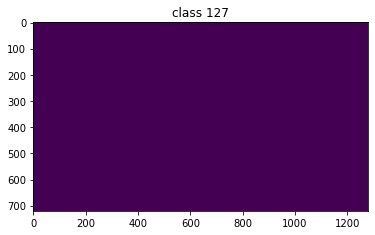

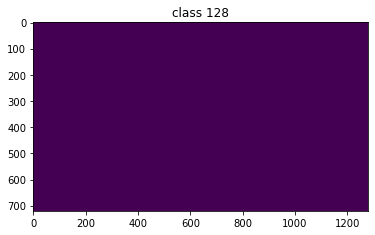

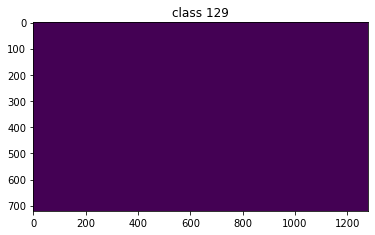

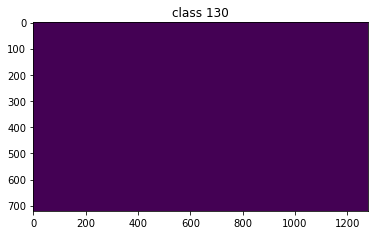

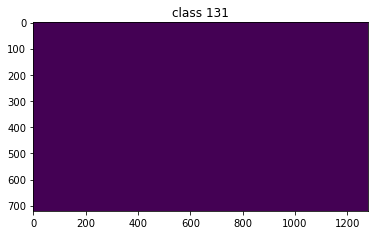

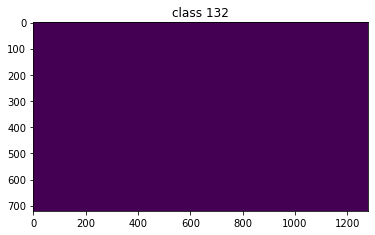

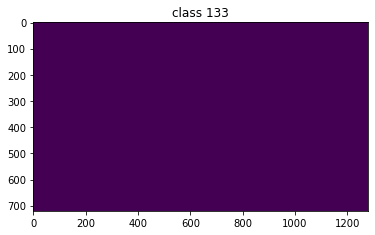

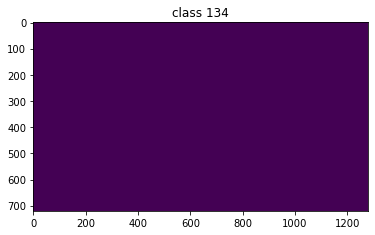

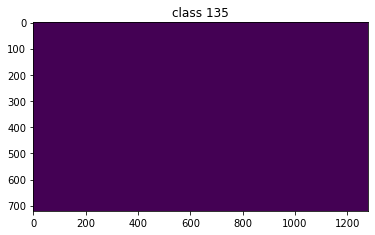

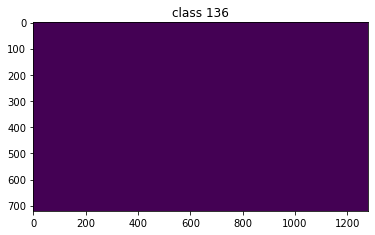

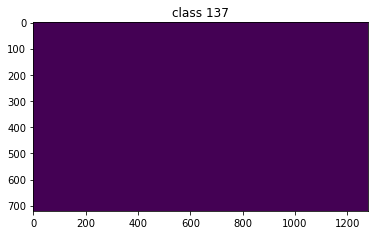

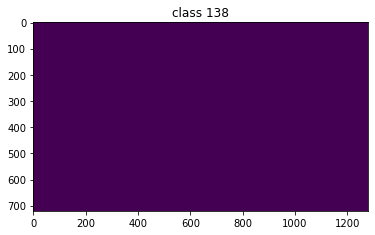

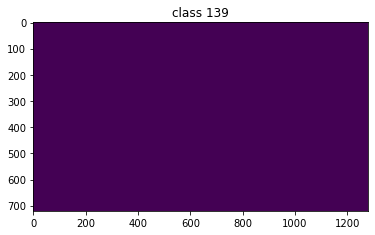

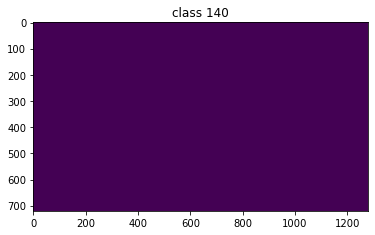

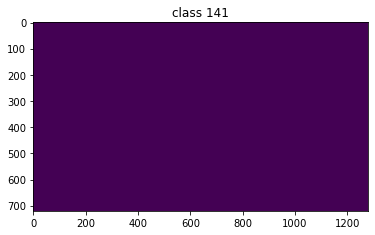

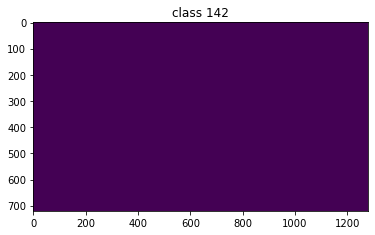

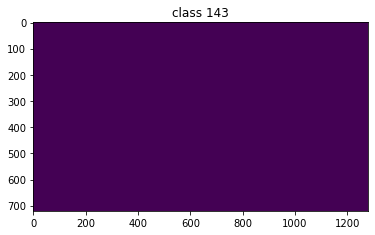

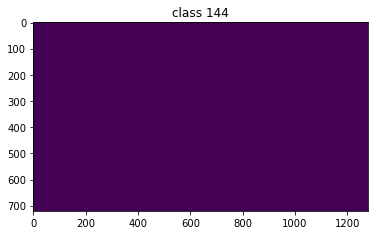

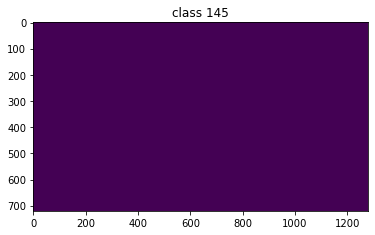

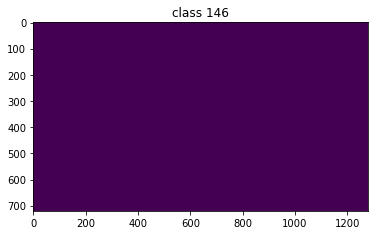

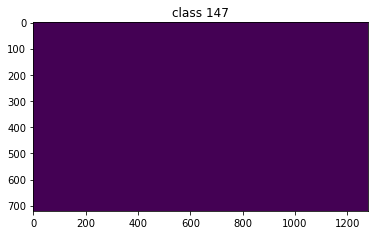

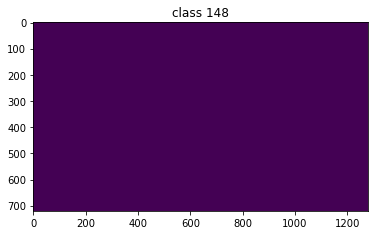

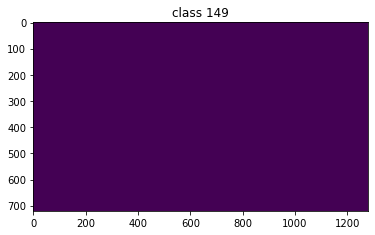

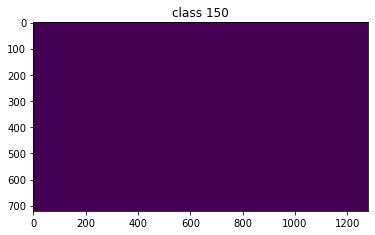

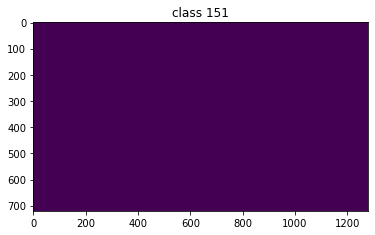

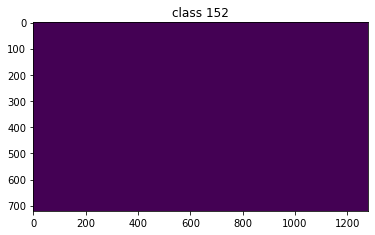

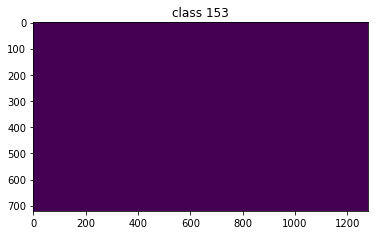

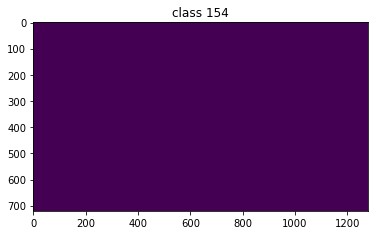

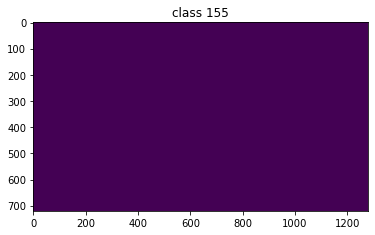

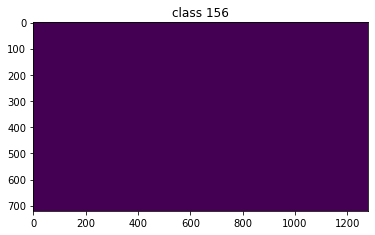

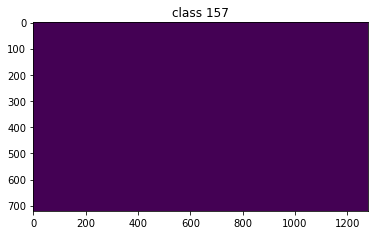

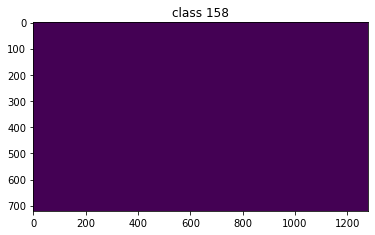

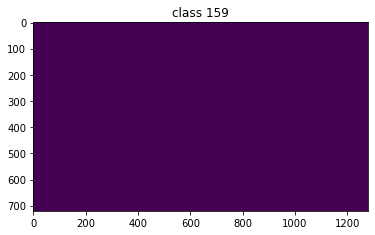

In [58]:
for i in range(class_count):
    mask = plt.imread('set-lipstick-original/mask/mask00000001.png')*255
    mask = np.where(mask == i, 255, 0)
    mask = mask[:,:,0]
    plt.title(f'class {i}')
    plt.imshow(mask)
    plt.show()

Теперь приведем наш датасет к удобному виду, для этого сначала разделим все на два списка с rgb картинками и seg.

In [102]:
cameraRGB = []
cameraSeg = []
for root, dirs, files in os.walk('set-lipstick-original'):
    for name in files:
        f = os.path.join(root, name)
        if '720p' in f:
            cameraRGB.append(f)
        elif 'mask' in f:
            cameraSeg.append(f)
        else:
            break

In [103]:
images_to_remove=[]
for image_name in cameraRGB:
    #print(image_name.replace("720p\image","mask\mask").replace(".jpg",".png"))
    if image_name.replace("720p\image","mask\mask").replace(".jpg",".png") not in cameraSeg:
        images_to_remove.append(image_name)      

for image_name_remove in images_to_remove:
    cameraRGB.remove(image_name_remove)


In [104]:
seqs_to_remove=[]
for seq_name in cameraSeg:
    if seq_name.replace("mask\mask","720p\image").replace(".png",".jpg") not in cameraRGB:        
        seqs_to_remove.append(seq_name)
        
for seq_name_remove in seqs_to_remove:
    cameraSeg.remove(seq_name_remove)


In [105]:
print(len(cameraSeg))
print(len(cameraRGB))

28540
28540


In [106]:
df = pd.DataFrame({'cameraRGB': cameraRGB, 'cameraSeg': cameraSeg})
# Отсортируем  датафрейм по значениям
df.sort_values(by='cameraRGB',inplace=True)
# Используем функцию,
# лагодаря которой индексация значений 
# будет начинаться с 0.
df.reset_index(drop=True, inplace=True)
# Выведем первые ять значений нашего датафрейма
print(df.head(5))

                                      cameraRGB  \
0  set-lipstick-original\720p\image00000001.jpg   
1  set-lipstick-original\720p\image00000002.jpg   
2  set-lipstick-original\720p\image00000003.jpg   
3  set-lipstick-original\720p\image00000004.jpg   
4  set-lipstick-original\720p\image00000005.jpg   

                                     cameraSeg  
0  set-lipstick-original\mask\mask00000001.png  
1  set-lipstick-original\mask\mask00000002.png  
2  set-lipstick-original\mask\mask00000003.png  
3  set-lipstick-original\mask\mask00000004.png  
4  set-lipstick-original\mask\mask00000005.png  


Теперь обернем все в кастомный датасет для удобной работы в PyTorch.

In [107]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F

In [108]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 1) unsqueeze - меняет размерность img c (600, 800, 3) -> (1, 600, 800, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, 600, 800, 3) -> (1, 3, 600, 800)
        img = img.unsqueeze(0).permute(0,3,1,2)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять размерность картинки с 800х600 на 256х256
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
        # читаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        lab = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
        
        # Упаковываем ее в pytorch-тензор и оборачиваем ее в батч из одной каринки,
        # но при этом заполняем 12 каналов масками нужных классов
        # Т.е. там, где например класс автомобилей (10 по счету канал) - все пиксели 0 
        # если не принадлежат классу, и 1 если принадлежат 
        x_out = torch.as_tensor(np.where(lab == 0, 255, 0)).unsqueeze(0)
        for i in range(1, class_count):           
            mask = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
            mask = np.where(mask == i, 255, 0)
            x = torch.as_tensor(mask).unsqueeze(0)
            x_out =  torch.cat((x_out,x),dim=0)       
        x_out = x_out.float()
        
        lab = x_out.unsqueeze(0)
        # делаем ресайз картинки на 256х256
        lab = F.interpolate(input=lab, size=256, mode='nearest')
        
        
        
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

Затем разделим наш датасет на тренировочную и тестовую выборки.
И обернем их в наш кастомный класс.

In [109]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df,test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [110]:
train_data_loader = DataLoader(train_data,batch_size=1,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=1,shuffle=False)

**Обучение**

ЗАДАНИЕ 3. И затем обучить Модель на выбор из segmentation_models_pytorch

In [111]:
#Определим скорость обучения и количество эпох:
learning_rate = 0.001
epochs = 1 #5

In [112]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [114]:
!pip install segmentation_models_pytorch 

In [113]:
#Определим нашу модель Unet для class_count классов: 
print(class_count)


160


In [115]:
import segmentation_models_pytorch as smp

# создание модели
segmodel = smp.Unet()
segmodel = smp.Unet('resnet34', classes=class_count, activation='softmax').to(device)

epoch_losses = []

for epoch in range(epochs):  # 20 loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = []
    t = 0
    time1 = time.time()
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #inputs = inputs.cuda()
        #labels = labels.cuda()


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = segmodel(inputs[0])
        loss = criterion(outputs,labels[0,0,:,:,:]) #dice_loss
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        t+=1
        if t % 5000 == 4999:    # print every 5000 mini-batches
            print(f'Epoch: {epoch}, batchcount: {t}, avg. loss for last 5000 images: {running_loss/5000}')
    time2 = time.time()
    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss),f' time = {time2-time1} sec')
    epoch_losses.append(epoch_loss)

C:\Users\Windows\Anaconda3\envs\python38\lib\site-packages\segmentation_models_pytorch\base\modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
C:\Users\Windows\Anaconda3\envs\python38\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


KeyboardInterrupt: 

In [119]:
len(epoch_loss)

640

In [116]:
savePATH = './segmodel.pth'
torch.save(segmodel.state_dict(), savePATH)

In [117]:
net=smp.Unet('resnet34', classes=class_count, activation='softmax').to(device)
net.load_state_dict(torch.load(savePATH))

<All keys matched successfully>

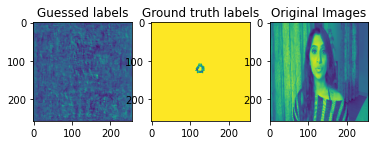

<ipython-input-118-fd8fc7563aff>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.gcf().show()


<Figure size 432x288 with 0 Axes>

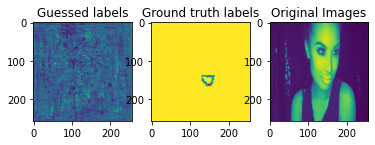

<Figure size 432x288 with 0 Axes>

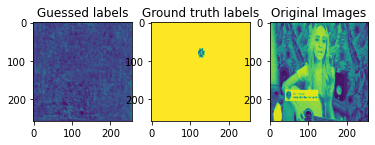

<Figure size 432x288 with 0 Axes>

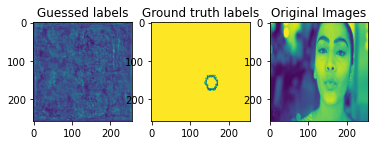

<Figure size 432x288 with 0 Axes>

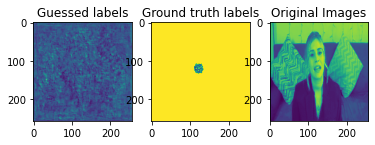

<Figure size 432x288 with 0 Axes>

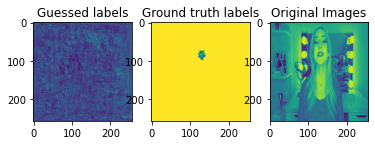

<Figure size 432x288 with 0 Axes>

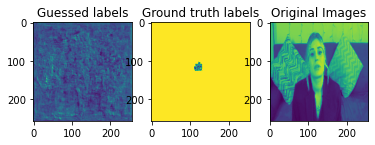

<Figure size 432x288 with 0 Axes>

In [118]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    outputs = net(images[0])
    f, axarr = plt.subplots(1,3)

    axarr[0].imshow(outputs[0].detach().cpu().numpy()[1,:,:])
    axarr[0].set_title('Guessed labels')
    
    axarr[1].imshow(labels[0].detach().cpu().numpy()[0,0,:,:])
    axarr[1].set_title('Ground truth labels')
    
    axarr[2].imshow(images[0].detach().cpu().numpy()[0,0,:,:])
    axarr[2].set_title('Original Images')
    plt.show()
    plt.gcf().show()
    if i>5:
        break

**Сеть обучалась более 3.5 часов и нет возможности дальше продолжать ее обучать - прервал выполнение, не дождавшись, т.к. нет NVIDIA и CUDA библиотеки и все обучается на CPU**